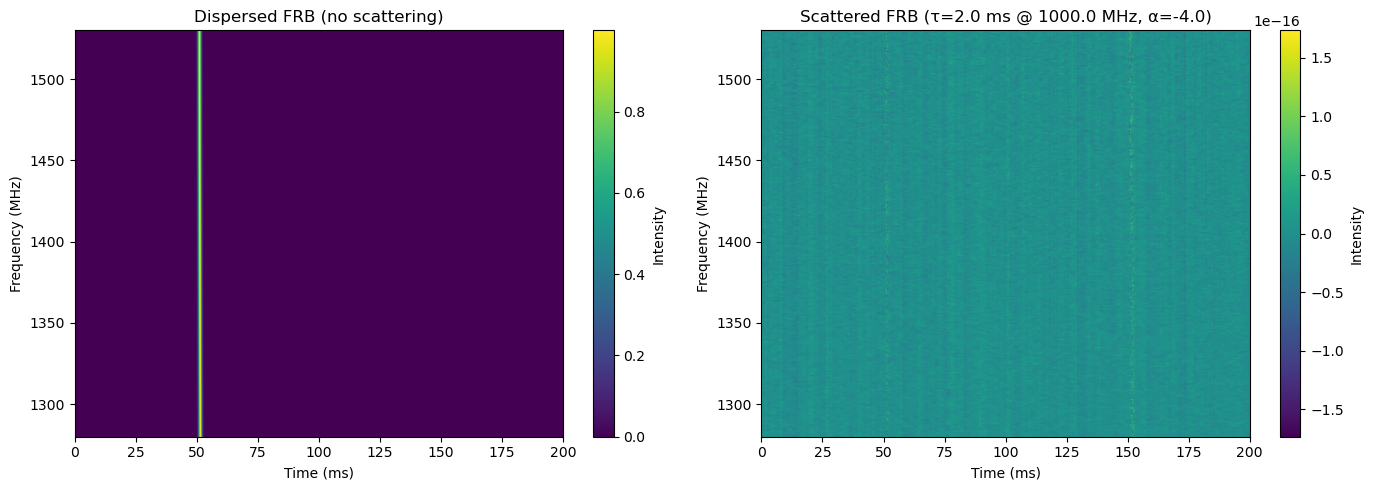

Scattering at 1280 MHz: τ = 0.75 ms
Scattering at 1530 MHz: τ = 0.36 ms


In [2]:
from flits.models import FRBModel
from flits.params import FRBParams
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# Define the FRB parameters
params = FRBParams(
    dm=500.0,           # Dispersion measure (pc/cm³)
    amplitude=1.0,      # Peak intensity
    t0=50.0,            # Reference arrival time (ms)
    width=0.5,          # Gaussian width (ms)
)

model = FRBModel(params)

# Create time and frequency axes
t = np.linspace(0, 200, 2048)           # Time in ms
freqs = np.linspace(1280, 1530, 256)    # Frequency in MHz (DSA-110 band)
dt = t[1] - t[0]  # Time resolution in ms

# Generate the un-scattered dynamic spectrum
dynspec = model.simulate(t, freqs)

# --- Add scattering tail ---
# Scattering timescale at reference frequency (ms)
tau_ref = 2.0        # τ_scat at ν_ref in ms
nu_ref = 1000.0      # Reference frequency in MHz
alpha_scat = -4.0    # Frequency scaling: τ ∝ ν^α (typically -4 to -4.4)

def scatter_profile(tau_ms, t_grid, dt):
    """Create one-sided exponential scattering kernel."""
    # Only positive delays
    kernel = np.exp(-t_grid / tau_ms)
    kernel[t_grid < 0] = 0
    kernel /= kernel.sum() * dt  # Normalize to preserve flux
    return kernel

# Apply frequency-dependent scattering to each channel
dynspec_scattered = np.zeros_like(dynspec)
for i, nu in enumerate(freqs):
    # Scattering time at this frequency
    tau_nu = tau_ref * (nu / nu_ref) ** alpha_scat
    
    # Create scattering kernel centered at t=0
    t_kernel = t - t[0]  # Shift to start at 0 for causal kernel
    kernel = scatter_profile(tau_nu, t_kernel, dt)
    
    # Convolve the pulse with scattering kernel
    scattered = fftconvolve(dynspec[i], kernel, mode='same') * dt
    dynspec_scattered[i] = scattered

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original (no scattering)
im0 = axes[0].imshow(dynspec, aspect='auto', origin='lower',
                     extent=[t.min(), t.max(), freqs.min(), freqs.max()])
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Frequency (MHz)')
axes[0].set_title(f'Dispersed FRB (no scattering)')
plt.colorbar(im0, ax=axes[0], label='Intensity')

# With scattering
im1 = axes[1].imshow(dynspec_scattered, aspect='auto', origin='lower',
                     extent=[t.min(), t.max(), freqs.min(), freqs.max()])
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Frequency (MHz)')
axes[1].set_title(f'Scattered FRB (τ={tau_ref} ms @ {nu_ref} MHz, α={alpha_scat})')
plt.colorbar(im1, ax=axes[1], label='Intensity')

plt.tight_layout()
plt.show()

print(f"Scattering at {freqs.min():.0f} MHz: τ = {tau_ref * (freqs.min()/nu_ref)**alpha_scat:.2f} ms")
print(f"Scattering at {freqs.max():.0f} MHz: τ = {tau_ref * (freqs.max()/nu_ref)**alpha_scat:.2f} ms")